In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
import xlsxwriter

import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from classify_campaigns import classify_campaigns

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [3]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')
imp_type

impression type  imp_type_id
0                                            display            1
1                                              video            2
2                                             native            4
3                                       native video            8
4                                     rewarded video           16
5                                                IBV           32
6                                    rewarded banner           64
7                           rewarded video + display           17
8                             rewarded video + video           18
9                            rewarded video + native           20
10                     rewarded video + native video           24
11                                     IBV + display           33
12                                       IBV + video           34
13                                      IBV + native           36
14                                IBV + native video           40
15                              IBV + rewarded video           48
16                         rewarded banner + display           65
17                           rewarded banner + video           66
18                          rewarded banner + native           68
19                    rewarded banner + native video           72
20                  rewarded banner + rewarded video           80
21                             rewarded banner + IBV           96
22                             IBV + video + display           35
23                    IBV + rewarded video + display           49
24  rewarded banner + IBV + rewarded video + display          113

In [4]:
start_dt = '2021-10-01'
end_dt = '2021-10-14'
change_dt = '2021-08-30'


Smartnews 
- enabling of deal id - we want to switch revenue over to Fyber from other exchanges
1. Get overlapping pubs (pub campaign ad_type) between Fyber and other exchanges (broken out by exchange)
	- Applovin, InMobi, Mopub, Unity
2. Target pub on Fyber with deal id 

cross appreciate
AppLovin x Fyber - competetitve analysis 
1. Overlapping pubs
2. exclusive pubs
3. sizes 
4. number of pubs 

In [8]:
def calc_metrics(df, i = 0):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['cpm'] = 1000*df['cost']/df['impressions']

    if i != 0:
        df['cost_sov'] = 100*df['cost']/df.groupby(i)['cost'].transform(sum)
        df['revenue_sov'] = 100*df['revenue']/df.groupby(i)['revenue'].transform(sum)
        df['total_cost'] = df.groupby(i)['cost'].transform(sum)
    else:
        df['cost_sov'] = 100*df['cost']/df['cost'].sum()
        df['revenue_sov'] = 100*df['revenue']/df['revenue'].sum()
        df['total_cost'] = df.cost
    df['profit'] = df['revenue']-df['cost']
    df['margin'] = 100*df['profit']/df['revenue']
    return df[['impressions','clicks','ctr','installs','ir','ipm','cpm','revenue','revenue_sov','cost','cost_sov','profit','margin','total_cost']]

In [6]:
df_stats = bigquery_client.query(f"""
select
    c.name as campaign_name
    , r.ssb_campaign_uuid
    , r.hosting_app_id
    , p.name as hosting_app_name
    , p.bundle as hosting_bnd
    , sp.name as sponsored_app_name
    , r.ssb_buyer_id
    , r.exchange_id
    , ad_type
    , r.imp_type
    , r.ad_size
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*16 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*16 as installs
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as revenue
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
    , sum(case when event_type = 'clear' then bid_price else 0 end)*16/1000 as bid
from stats.rows1 r
left join metadata.campaigns c
    on r.ssb_campaign_uuid = c.uuid  
join metadata.apps p
    on r.hosting_app_id = p.app_id
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and right(r.id,1) in ('0')
group by 1,2,3,4,5,6,7,8,9,10,11
""").to_dataframe()
df_stats = df_stats.set_index('exchange_id').join(exchange.set_index('exchange_id'), how = 'left').reset_index()
df_stats = df_stats.set_index('imp_type').join(imp_type.set_index('imp_type_id'), how = 'left').reset_index()
df_stats['experience_type'] = df_stats.apply(lambda x:classify_campaigns(x), axis = 1)
df_stats

index  exchange_id                                  campaign_name  \
0          1.0            1          Android-Pandora-Pandora-US-5-AdColony   
1          1.0            1                    Audible_UK_ST_Banner_AUK010   
2          1.0            1   Android-SmartNews Inc-SmartNews-US-Cricket-2   
3          1.0            1                          Hair Challenge_CA_iOS   
4          1.0            1  Particle Media - News Break - US - Cricket UA   
...        ...          ...                                            ...   
1373367    NaN           41                Who Is?_Android_US_ST_Vid+Inter   
1373368    NaN           41                     Playsimple-Word Jam-US-RON   
1373369    NaN           44        SmartNews_Tracfone_SingleTap_All_CPI_NA   
1373370    NaN           44                     Pandora - Pandora - US - 1   
1373371    NaN           44     DT-SingleTap-DSP-PlaySimple-WordTrip-US-UA   

                        ssb_campaign_uuid  hosting_app_id  \
0        28cab68e383d553e67cda191ce0d409d         1178774   
1        374edbfb0c7d9133932c05986e1e1f95         1178774   
2        545149fc54f7c1283d6c0c90ab8ce7e2         1062757   
3        18b40844826790ebd9939885d2023056      1451505313   
4        fe64a9f1d0e4986d64879d60781f14cf         1200506   
...                                   ...             ...   
1373367  d72d7bcc2dde86f11ce0d6efbe719064         1314457   
1373368  d68c7b0af30354df7c23485a57b8f17e         1184975   
1373369  d8be47c87ebd5047c552f92421103f1a         1076473   
1373370  30bc823acca34196010b05475c5d77ec          380896   
1373371  3bf043901874bb0ef510dc88b8a764ad          786482   

                                    hosting_app_name  \
0                          Mr Ninja - Slicey Puzzles   
1                          Mr Ninja - Slicey Puzzles   
2                         Solitaire TriPeaks Journey   
3                                            Draw it   
4                                     What The Fight   
...                                              ...   
1373367                               Kiss in Public   
1373368  Word Connect - Lucky Puzzle Game to Big Win   
1373369               Color by Number: Coloring Game   
1373370                                   Temple Run   
1373371                    Juice Jam - Match 3 Games   

                                          hosting_bnd  \
0                             com.lionstudios.mrninja   
1                             com.lionstudios.mrninja   
2                                 com.me2zen.tripeaks   
3                                          1451505313   
4                             com.appadvisory.wtfight   
...                                               ...   
1373367                 kr.co.alohacorp.BlasttheGiant   
1373368                  com.dreamstudio.word.connect   
1373369  com.tfgco.apps.coloring.free.color.by.number   
1373370                          com.imangi.templerun   
1373371                       air.com.sgn.juicejam.gp   

                                    sponsored_app_name  ssb_buyer_id ad_type  \
0          Pandora - Streaming Music, Radio & Podcasts          3549   inter   
1        Audible: audiobooks, podcasts & audio stories           674  banner   
2                       SmartNews: Local Breaking News          3549   inter   
3                                       Hair Challenge          3246  banner   
4                       NewsBreak: Local News & Alerts          3549  banner   
...                                                ...           ...     ...   
1373367                 Who is? Brain Teaser & Riddles          3669    None   
1373368                                  Crossword Jam          3549    None   
1373369                 SmartNews: Local Breaking News          3549    None   
1373370    Pandora - Streaming Music, Radio & Podcasts          3549    None   
1373371                                      Word Trip          3549    None   

         ad_size  im

# General Fyber x AppLovin

In [6]:
format_map = {'impressions':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'revenue':'${:,.0f}'
             ,'cost':'${:,.0f}'
             ,'profit':'${:,.0f}'
             ,'cpm':'${:,.2f}'
             ,'ctr':'{:,.1f}%'
             ,'margin':'{:,.0f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'revenue_sov':'{:,.1f}%'
             ,'uninstall_rate':'{:,.0f}%'
             ,'cost_sov':'{:,.1f}%'
             ,'imp_sov':'{:,.1f}%'
             ,'impressions_fyber':'{:,.0f}'
             ,'clicks_fyber':'{:,.0f}'
             ,'installs_fyber':'{:,.0f}'
             ,'revenue_fyber':'${:,.0f}'
             ,'cost_fyber':'${:,.0f}'
             ,'cpm_fyber':'${:,.2f}'
             ,'ctr_fyber':'{:,.1f}%'
             ,'ir_fyber':'{:,.1f}%'
             ,'ipm_fyber':'{:,.2f}'
             ,'revenue_sov_fyber':'{:,.1f}%'
             ,'imp_sov_fyber':'{:,.1f}%'
             ,'impressions_AppLovin':'{:,.0f}'
             ,'clicks_AppLovin':'{:,.0f}'
             ,'installs_AppLovin':'{:,.0f}'
             ,'revenue_AppLovin':'${:,.0f}'
             ,'cost_AppLovin':'${:,.0f}'
             ,'cpm_AppLovin':'${:,.2f}'
             ,'ctr_AppLovin':'{:,.1f}%'
             ,'ir_AppLovin':'{:,.1f}%'
             ,'ipm_AppLovin':'{:,.2f}'
             ,'revenue_sov_AppLovin':'{:,.1f}%'
             ,'imp_sov_AppLovin':'{:,.1f}%'}

In [7]:
overall = df_stats[(df_stats.exchange_name.isin(['Fyber','AppLovin']))].groupby(['exchange_name'])['impressions','clicks','installs','revenue','cost'].sum()
overall = calc_metrics(overall)
overall.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm'])

<ipython-input-7-31f2ddeaa6ee>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  overall = df_stats[(df_stats.exchange_name.isin(['Fyber','AppLovin']))].groupby(['exchange_name'])['impressions','clicks','installs','revenue','cost'].sum()


In [8]:
pivot = df_stats[(df_stats.exchange_name.isin(['Fyber','AppLovin']))].groupby(['experience_type','exchange_name'])['impressions','clicks','installs','revenue','cost'].sum()
pivot = calc_metrics(pivot)
pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm'])

<ipython-input-8-574d1fb9ffe7>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pivot = df_stats[(df_stats.exchange_name.isin(['Fyber','AppLovin']))].groupby(['experience_type','exchange_name'])['impressions','clicks','installs','revenue','cost'].sum()


In [9]:
fyber = df_stats[(df_stats.exchange_name == 'Fyber')].groupby(['hosting_app_name','hosting_bnd'])['impressions','clicks','installs','revenue','cost'].sum()
fyber = calc_metrics(fyber)

x = 'AppLovin'
x_pubs = df_stats[df_stats.exchange_name == x].groupby(['hosting_app_name','hosting_bnd'])['impressions','clicks','installs','revenue','cost'].sum()
x_pubs = calc_metrics(x_pubs)
joined = x_pubs.join(fyber, how = 'outer', rsuffix = '_fyber', lsuffix = f'_{x}')
joined['cost_pct'] = joined[f'cost_{x}']/joined.cost_fyber - 1
joined['cpm_pct'] = joined[f'cpm_{x}']/joined.cpm_fyber - 1
joined['impressions_pct'] = joined[f'impressions_{x}']/joined.impressions_fyber - 1
joined['ctr_pct'] = joined[f'ctr_{x}']/joined.ctr_fyber - 1
joined['ir_pct'] = joined[f'ir_{x}']/joined.ir_fyber - 1
joined['ipm_pct'] = joined[f'ipm_{x}']/joined.ipm_fyber - 1
joined['revenue_pct'] = joined[f'revenue_{x}']/joined.revenue_fyber - 1
joined.sort_values([f'cost_{x}',f'impressions_{x}'], ascending = False, inplace = True)
joined = joined[[f'cost_{x}','cost_fyber','cost_pct',f'cpm_{x}','cpm_fyber','cpm_pct',f'impressions_{x}','impressions_fyber','impressions_pct',f'ctr_{x}','ctr_fyber','ctr_pct',f'ir_{x}','ir_fyber','ir_pct',f'ipm_{x}','ipm_fyber','ipm_pct',f'revenue_{x}','revenue_fyber','revenue_pct']]
joined.head(5)

<ipython-input-9-d8def4b8b1c6>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  fyber = df_stats[(df_stats.exchange_name == 'Fyber')].groupby(['hosting_app_name','hosting_bnd'])['impressions','clicks','installs','revenue','cost'].sum()
<ipython-input-9-d8def4b8b1c6>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  x_pubs = df_stats[df_stats.exchange_name == x].groupby(['hosting_app_name','hosting_bnd'])['impressions','clicks','installs','revenue','cost'].sum()


cost_AppLovin  \
hosting_app_name              hosting_bnd                               
Magic Tiles 3                 com.youmusic.magictiles    27888.308496   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks   26343.862784   
Subway Surfers                com.kiloo.subwaysurf       17969.682064   
Tiles Hop: EDM Rush!          com.amanotes.beathopper    16934.356768   
Wordscapes                    com.peoplefun.wordcross    16361.627552   

                                                         cost_fyber  \
hosting_app_name              hosting_bnd                             
Magic Tiles 3                 com.youmusic.magictiles   3797.247938   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks  1111.547737   
Subway Surfers                com.kiloo.subwaysurf              NaN   
Tiles Hop: EDM Rush!          com.amanotes.beathopper   1231.645824   
Wordscapes                    com.peoplefun.wordcross   5259.381777   

                                                         cost_pct  \
hosting_app_name              hosting_bnd                           
Magic Tiles 3                 com.youmusic.magictiles    6.344348   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks  22.700163   
Subway Surfers                com.kiloo.subwaysurf            NaN   
Tiles Hop: EDM Rush!          com.amanotes.beathopper   12.749372   
Wordscapes                    com.peoplefun.wordcross    2.110941   

                                                        cpm_AppLovin  \
hosting_app_name              hosting_bnd                              
Magic Tiles 3                 com.youmusic.magictiles      17.823741   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks     43.582187   
Subway Surfers                com.kiloo.subwaysurf         31.210369   
Tiles Hop: EDM Rush!          com.amanotes.beathopper       9.424815   
Wordscapes                    com.peoplefun.wordcross       3.397991   

                                                        cpm_fyber   cpm_pct  \
hosting_app_name              hosting_bnd                                     
Magic Tiles 3                 com.youmusic.magictiles    6.970599  1.556988   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks  10.730883  3.061380   
Subway Surfers                com.kiloo.subwaysurf            NaN       NaN   
Tiles Hop: EDM Rush!          com.amanotes.beathopper    2.167475  3.348293   
Wordscapes                    com.peoplefun.wordcross    1.239083  1.742344   

                                                        impressions_AppLovin  \
hosting_app_name              hosting_bnd                                      
Magic Tiles 3                 com.youmusic.magictiles              1564672.0   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks              604464.0   
Subway Surfers                com.kiloo.subwaysurf                  575760.0   
Tiles Hop: EDM Rush!          com.amanotes.beathopper              1796784.0   
Wordscapes                    com.peoplefun.wordcross              4815088.0   

                                                        impressions_fyber  \
hosting_app_name              hosting_bnd                                   
Magic Tiles 3                 com.youmusic.magictiles            544752.0   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks           103584.0   
Subway Surfers                com.kiloo.subwaysurf                    NaN   
Tiles Hop: EDM Rush!          com.amanotes.beathopper            568240.0   
Wordscapes                    com.peoplefun.wordcross           4244576.0   

                                                        impressions_pct  \
hosting_app_name              hosting_bnd                                 
Magic Tiles 3                 com.youmusic.magictiles          1.872265   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks         4.835496   
Subway Surfers                com.kiloo.subwaysurf                  NaN   
Tiles Hop: EDM Rush!       

In [10]:
fyber_type_size = df_stats[(df_stats.exchange_name == 'Fyber')].groupby(['hosting_app_name','hosting_bnd','impression type','ad_type'])['impressions','clicks','installs','revenue','cost'].sum()
fyber_type_size = calc_metrics(fyber_type_size)

x = 'AppLovin'
x_pubs_type_size = df_stats[df_stats.exchange_name == x].groupby(['hosting_app_name','hosting_bnd','impression type','ad_type'])['impressions','clicks','installs','revenue','cost'].sum()
x_pubs_type_size = calc_metrics(x_pubs_type_size)
joined_type_size = x_pubs_type_size.join(fyber_type_size, how = 'outer', rsuffix = '_fyber', lsuffix = f'_{x}')
joined_type_size['cost_pct'] = joined_type_size[f'cost_{x}']/joined_type_size.cost_fyber - 1
joined_type_size['cpm_pct'] = joined_type_size[f'cpm_{x}']/joined_type_size.cpm_fyber - 1
joined_type_size['impressions_pct'] = joined_type_size[f'impressions_{x}']/joined_type_size.impressions_fyber - 1
joined_type_size['ctr_pct'] = joined_type_size[f'ctr_{x}']/joined_type_size.ctr_fyber - 1
joined_type_size['ir_pct'] = joined_type_size[f'ir_{x}']/joined_type_size.ir_fyber - 1
joined_type_size['ipm_pct'] = joined_type_size[f'ipm_{x}']/joined_type_size.ipm_fyber - 1
joined_type_size['revenue_pct'] = joined_type_size[f'revenue_{x}']/joined_type_size.revenue_fyber - 1
joined_type_size.sort_values([f'cost_{x}',f'impressions_{x}'], ascending = False, inplace = True)
joined_type_size = joined_type_size[[f'cost_{x}','cost_fyber','cost_pct',f'cpm_{x}','cpm_fyber','cpm_pct',f'impressions_{x}','impressions_fyber','impressions_pct',f'ctr_{x}','ctr_fyber','ctr_pct',f'ir_{x}','ir_fyber','ir_pct',f'ipm_{x}','ipm_fyber','ipm_pct',f'revenue_{x}','revenue_fyber','revenue_pct']]
joined_type_size.head(5)

<ipython-input-10-4efe1033e5e4>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  fyber_type_size = df_stats[(df_stats.exchange_name == 'Fyber')].groupby(['hosting_app_name','hosting_bnd','impression type','ad_type'])['impressions','clicks','installs','revenue','cost'].sum()
<ipython-input-10-4efe1033e5e4>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  x_pubs_type_size = df_stats[df_stats.exchange_name == x].groupby(['hosting_app_name','hosting_bnd','impression type','ad_type'])['impressions','clicks','installs','revenue','cost'].sum()


cost_AppLovin  \
hosting_app_name              hosting_bnd              impression type ad_type                  
Subway Surfers                com.kiloo.subwaysurf     rewarded video  inter     12615.504368   
Magic Tiles 3                 com.youmusic.magictiles  video           inter     12430.154176   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks rewarded video  inter     11757.866400   
Magic Tiles 3                 com.youmusic.magictiles  rewarded video  inter      9953.992080   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks video           inter      9104.203904   

                                                                                 cost_fyber  \
hosting_app_name              hosting_bnd              impression type ad_type                
Subway Surfers                com.kiloo.subwaysurf     rewarded video  inter            NaN   
Magic Tiles 3                 com.youmusic.magictiles  video           inter    1079.578564   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks rewarded video  inter     313.604429   
Magic Tiles 3                 com.youmusic.magictiles  rewarded video  inter     342.413501   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks video           inter     379.122381   

                                                                                 cost_pct  \
hosting_app_name              hosting_bnd              impression type ad_type              
Subway Surfers                com.kiloo.subwaysurf     rewarded video  inter          NaN   
Magic Tiles 3                 com.youmusic.magictiles  video           inter    10.513895   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks rewarded video  inter    36.492667   
Magic Tiles 3                 com.youmusic.magictiles  rewarded video  inter    28.070092   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks video           inter    23.013892   

                                                                                cpm_AppLovin  \
hosting_app_name              hosting_bnd              impression type ad_type                 
Subway Surfers                com.kiloo.subwaysurf     rewarded video  inter       35.873744   
Magic Tiles 3                 com.youmusic.magictiles  video           inter       30.918320   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks rewarded video  inter       48.143779   
Magic Tiles 3                 com.youmusic.magictiles  rewarded video  inter       66.801729   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks video           inter       39.266631   

                                                                                cpm_fyber  \
hosting_app_name              hosting_bnd              impression type ad_type              
Subway Surfers                com.kiloo.subwaysurf     rewarded video  inter          NaN   
Magic Tiles 3                 com.youmusic.magictiles  video           inter    23.379647   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks rewarded video  inter    12.227247   
Magic Tiles 3                 com.youmusic.magictiles  rewarded video  inter    14.042548   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks video           inter    18.642918   

                                                                                 cpm_pct  \
hosting_app_name              hosting_bnd              impression type ad_type             
Subway Surfers                com.kiloo.subwaysurf     rewarded video  inter         NaN   
Magic Tiles 3                 com.youmusic.magictiles  video           inter    0.322446   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks rewarded video  inter    2.937418   
Magic Tiles 3                 com.youmusic.magictiles  rewarded video  inter    3.757094   
Solitaire TriPeaks Card Games com.gsn.android.tripeaks video           inter    1.106249   

                                                                                impressions_AppLovin  \
hosting_

In [11]:
overlap = joined.loc[(joined.impressions_fyber > 0) & (joined.impressions_AppLovin > 0)]
overlap['cost_diff'] = overlap[f'cost_{x}']/overlap[f'cost_fyber'] - 1
overlap.head(30).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr_fyber','ir_fyber','ipm_fyber','cpm_fyber','ctr_AppLovin','ir_AppLovin','ipm_AppLovin','cpm_AppLovin'])

<ipython-input-11-a1268f32c985>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlap['cost_diff'] = overlap[f'cost_{x}']/overlap[f'cost_fyber'] - 1


In [12]:
overlap_type_size = joined_type_size.loc[(joined_type_size.impressions_fyber > 0) & (joined_type_size.impressions_AppLovin > 0)]
overlap_type_size['cost_diff'] = overlap_type_size[f'cost_{x}']/overlap_type_size[f'cost_fyber'] - 1
overlap_type_size.head(30).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr_fyber','ir_fyber','ipm_fyber','cpm_fyber','ctr_AppLovin','ir_AppLovin','ipm_AppLovin','cpm_AppLovin'])

<ipython-input-12-a1df286a2e5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlap_type_size['cost_diff'] = overlap_type_size[f'cost_{x}']/overlap_type_size[f'cost_fyber'] - 1


In [13]:
print(overlap.shape)
overlap.to_csv(f'~/Downloads/fyber_applovin_overlap_pubs_{start_dt}_{end_dt}.csv')
overlap_type_size.to_csv(f'~/Downloads/fyber_applovin_overlap_pubs_bundle_type_size_{start_dt}_{end_dt}.csv')

(4739, 22)


<ipython-input-14-248f23b57f58>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlap.sort_values('cost_fyber', ascending = False, inplace = True)


[Text(1, 0, 'ipm_AppLovin'), Text(2, 0, 'ipm_Fyber')]

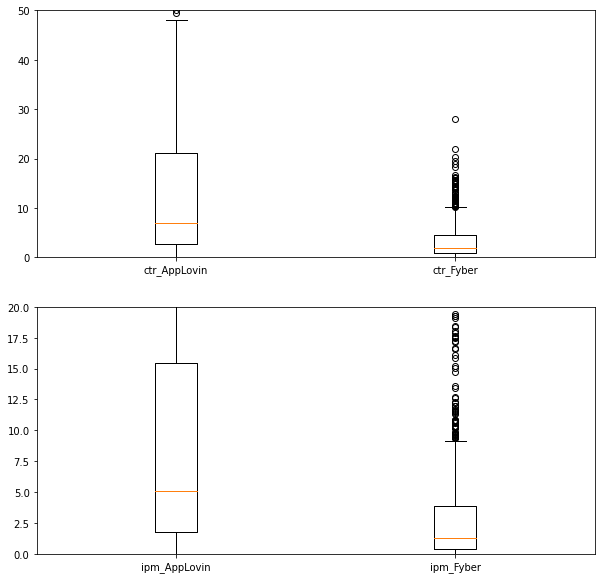

In [14]:
overlap.sort_values('cost_fyber', ascending = False, inplace = True)

fig, ax = plt.subplots(2,1,figsize = (10,10))
ax[0].boxplot([overlap[:1000].loc[:, 'ctr_AppLovin'], overlap[:1000].loc[:, 'ctr_fyber']])
ax[0].set_ylim(0,50)
ax[0].set_xticklabels(['ctr_AppLovin','ctr_Fyber'])
ax[1].boxplot([overlap[:1000].loc[:, 'ipm_AppLovin'], overlap[:1000].loc[:, 'ipm_fyber']])
ax[1].set_ylim(0,20)
ax[1].set_xticklabels(['ipm_AppLovin','ipm_Fyber'])


In [15]:
exclusive_pubs = joined.loc[((joined.impressions_fyber == 0) | (joined.impressions_fyber.isna())) & (joined.impressions_AppLovin > 0)]
exclusive_pubs.sort_values('cost_AppLovin', ascending = False,inplace = True)
exclusive_pubs.head(30).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr_fyber','ir_fyber','ipm_fyber','cpm_fyber','ctr_AppLovin','ir_AppLovin','ipm_AppLovin','cpm_AppLovin'])

<ipython-input-15-5b285b302bc9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclusive_pubs.sort_values('cost_AppLovin', ascending = False,inplace = True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


In [16]:
exclusive_type_size = joined_type_size.loc[((joined_type_size.impressions_fyber == 0) | (joined_type_size.impressions_fyber.isna())) & (joined_type_size.impressions_AppLovin > 0)]
exclusive_type_size.sort_values('cost_AppLovin', ascending = False,inplace = True)
exclusive_type_size.head(30).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr_fyber','ir_fyber','ipm_fyber','cpm_fyber','ctr_AppLovin','ir_AppLovin','ipm_AppLovin','cpm_AppLovin'])

<ipython-input-16-4248ab25beaf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclusive_type_size.sort_values('cost_AppLovin', ascending = False,inplace = True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


In [17]:
print(exclusive_pubs.shape)
exclusive_pubs.to_csv(f'~/Downloads/fyber_applovin_exclusive_pubs_{start_dt}_{end_dt}.csv')
exclusive_type_size.to_csv(f'~/Downloads/fyber_applovin_exclusive_pubs_bundle_type_size_{start_dt}_{end_dt}.csv')

(20707, 21)


In [18]:
def classify_overlap(r):
    if r.impressions_AppLovin > 0 and (r.impressions_fyber == 0 or pd.isna(r.impressions_fyber)):
        return 'AppLovin only'
    elif (r.impressions_AppLovin == 0 or pd.isna(r.impressions_AppLovin)) and r.impressions_fyber > 0:
        return 'Fyber only'
    elif r.impressions_AppLovin > 0 and r.impressions_fyber > 0:
        return 'Both'
    else:
        return 'Neither'
    
joined['overlap'] = joined.apply(lambda x:classify_overlap(x), axis = 1)

pivot = joined.reset_index().pivot_table(values = ('hosting_bnd','impressions_fyber','revenue_fyber','cost_fyber','impressions_AppLovin','revenue_AppLovin','cost_AppLovin'), index = 'overlap'
                           , aggfunc = {'impressions_fyber':np.sum,'revenue_fyber':np.sum,'cost_fyber':np.sum,'impressions_AppLovin':np.sum
                                        ,'revenue_AppLovin':np.sum,'cost_AppLovin':np.sum,'hosting_bnd':lambda x:len(x.unique())})
pivot.rename(columns={'hosting_bnd':'pub_bundle_ids'}, inplace=True)
pivot.style.format({'impressions_AppLovin':'{:,.0f}','impressions_fyber':'{:,.0f}','revenue_AppLovin':'${:,.0f}','revenue_fyber':'${:,.0f}','cost_AppLovin':'${:,.0f}','cost_fyber':'${:,.0f}'})

In [19]:
fyber = df_stats[(df_stats.exchange_name == 'Fyber')].groupby(['impression type','ad_size'])['impressions','clicks','installs','revenue','cost'].sum()
fyber = calc_metrics(fyber)

x = 'AppLovin'
x_type_size = df_stats[df_stats.exchange_name == x].groupby(['impression type','ad_size'])['impressions','clicks','installs','revenue','cost'].sum()
x_type_size = calc_metrics(x_type_size)
joined_type_size = x_type_size.join(fyber, how = 'outer', rsuffix = '_fyber', lsuffix = f'_{x}')
joined_type_size.sort_values([f'revenue_{x}',f'impressions_{x}'], ascending = False, inplace = True)
joined_type_size[['impressions_AppLovin','cost_AppLovin','revenue_AppLovin','impressions_fyber','cost_fyber']].head(15)

<ipython-input-19-fa35f3fae376>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  fyber = df_stats[(df_stats.exchange_name == 'Fyber')].groupby(['impression type','ad_size'])['impressions','clicks','installs','revenue','cost'].sum()
<ipython-input-19-fa35f3fae376>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  x_type_size = df_stats[df_stats.exchange_name == x].groupby(['impression type','ad_size'])['impressions','clicks','installs','revenue','cost'].sum()


impressions_AppLovin  cost_AppLovin  \
impression type ad_size                                         
video           768x1024            35848224.0  578275.025904   
display         320x50             301011808.0  232191.772096   
rewarded video  768x1024            10527056.0  235666.476832   
video           1024x768            10327296.0  152285.929264   
display         320x480              9535408.0  177909.811808   
rewarded video  1024x768             3840400.0   99142.437392   
display         480x320              4254864.0   61096.545168   
                728x90               3819520.0    3712.965504   
                300x250              5771936.0    2826.793712   
                1024x768                   NaN            NaN   
                768x1024                   NaN            NaN   

                          revenue_AppLovin  impressions_fyber     cost_fyber  
impression type ad_size                                                       
video           768x1024         612633.60          8386256.0   85252.454188  
display         320x50           262296.16        361912544.0  150715.985752  
rewarded video  768x1024         249135.84          3541568.0   31684.198855  
video           1024x768         173826.72          1235584.0    9628.633861  
display         320x480          145927.36         14231072.0  238059.183632  
rewarded video  1024x768          95419.04          1012512.0    8098.756637  
display         480x320           68088.48          1489344.0   14669.738291  
                728x90             2801.92                NaN            NaN  
                300x250            2092.64          5370320.0    2451.193898  
                1024x768               NaN            28112.0     354.998666  
                768x1024               NaN           145024.0    2041.939208

In [20]:
overlap_type_size = joined_type_size.loc[(joined_type_size.impressions_fyber > 0) & (joined_type_size.impressions_AppLovin > 0)]
overlap_type_size['cost_diff'] = overlap_type_size[f'cost_{x}']/overlap_type_size[f'cost_fyber'] - 1
overlap_type_size.to_csv(f'~/Downloads/fyber_applovin_overlap_type_size_pubs_type_size_{start_dt}_{end_dt}.csv')
overlap_type_size.head(30).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr_fyber','ir_fyber','ipm_fyber','cpm_fyber','ctr_AppLovin','ir_AppLovin','ipm_AppLovin','cpm_AppLovin'])

<ipython-input-20-9e89b7c33c35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlap_type_size['cost_diff'] = overlap_type_size[f'cost_{x}']/overlap_type_size[f'cost_fyber'] - 1


In [21]:
exclusive_size = joined_type_size.loc[((joined_type_size.cost_fyber < 0) | (joined_type_size.cost_fyber.isna())) & (joined_type_size.cost_AppLovin > 300)]
exclusive_size.sort_values('revenue_AppLovin', ascending = False, inplace = True)
exclusive_size#.style.format(format_map)

<ipython-input-21-f1b1c2e09fbd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclusive_size.sort_values('revenue_AppLovin', ascending = False, inplace = True)


impressions_AppLovin  clicks_AppLovin  ctr_AppLovin  \
impression type ad_size                                                        
display         728x90              3819520.0          42864.0      1.122235   

                         installs_AppLovin  ir_AppLovin  ipm_AppLovin  \
impression type ad_size                                                 
display         728x90              2160.0     5.039194      0.565516   

                         cpm_AppLovin  revenue_AppLovin  revenue_sov_AppLovin  \
impression type ad_size                                                         
display         728x90       0.972103           2801.92              0.173792   

                         cost_AppLovin  ...  installs_fyber  ir_fyber  \
impression type ad_size                 ...                             
display         728x90     3712.965504  ...             NaN       NaN   

                         ipm_fyber  cpm_fyber  revenue_fyber  \
impression type ad_size                                        
display         728x90         NaN        NaN            NaN   

                         revenue_sov_fyber  cost_fyber  cost_sov_fyber  \
impression type ad_size                                                  
display         728x90                 NaN         NaN             NaN   

                         profit_fyber  margin_fyber  
impression type ad_size                              
display         728x90            NaN           NaN  

[1 rows x 26 columns]

In [22]:
fyber_type_size = df_stats[(df_stats.exchange_name == 'Fyber')].groupby(['hosting_app_name','hosting_bnd','impression type','ad_size'])['impressions','clicks','installs','revenue','cost'].sum()
fyber_type_size = calc_metrics(fyber_type_size)

x = 'AppLovin'
x_pubs_type_size = df_stats[df_stats.exchange_name == x].groupby(['hosting_app_name','hosting_bnd','impression type','ad_size'])['impressions','clicks','installs','revenue','cost'].sum()
x_pubs_type_size = calc_metrics(x_pubs_type_size)
overlap_type_size = x_pubs_type_size.join(fyber_type_size, how = 'inner', rsuffix = '_fyber', lsuffix = f'_{x}')
overlap_type_size['cost_pct'] = overlap_type_size[f'cost_{x}']/overlap_type_size.cost_fyber - 1
overlap_type_size['cpm_pct'] = overlap_type_size[f'cpm_{x}']/overlap_type_size.cpm_fyber - 1
overlap_type_size['impressions_pct'] = overlap_type_size[f'impressions_{x}']/overlap_type_size.impressions_fyber - 1
overlap_type_size['ctr_pct'] = overlap_type_size[f'ctr_{x}']/overlap_type_size.ctr_fyber - 1
overlap_type_size['ir_pct'] = overlap_type_size[f'ir_{x}']/overlap_type_size.ir_fyber - 1
overlap_type_size['ipm_pct'] = overlap_type_size[f'ipm_{x}']/overlap_type_size.ipm_fyber - 1
overlap_type_size['revenue_pct'] = overlap_type_size[f'revenue_{x}']/overlap_type_size.revenue_fyber - 1
overlap_type_size.sort_values([f'cost_{x}',f'impressions_{x}'], ascending = False, inplace = True)
overlap_type_size = overlap_type_size[(overlap_type_size.impressions_AppLovin > 0) & (overlap_type_size.impressions_fyber > 0)]
overlap_type_size.to_csv(f'~/Downloads/fyber_applovin_overlap_pubs_type_size_{start_dt}_{end_dt}.csv')
overlap_type_size

<ipython-input-22-d59db4ea895c>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  fyber_type_size = df_stats[(df_stats.exchange_name == 'Fyber')].groupby(['hosting_app_name','hosting_bnd','impression type','ad_size'])['impressions','clicks','installs','revenue','cost'].sum()
<ipython-input-22-d59db4ea895c>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  x_pubs_type_size = df_stats[df_stats.exchange_name == x].groupby(['hosting_app_name','hosting_bnd','impression type','ad_size'])['impressions','clicks','installs','revenue','cost'].sum()


impressions_AppLovin  \
hosting_app_name               hosting_bnd                         impression type ad_size                          
Magic Tiles 3                  com.youmusic.magictiles             video           768x1024                401296   
Solitaire TriPeaks Card Games  com.gsn.android.tripeaks            rewarded video  1024x768                228928   
Magic Tiles 3                  com.youmusic.magictiles             rewarded video  768x1024                146928   
TextNow: Free US Calls & Texts com.enflick.android.TextNow         video           768x1024                 87216   
Solitaire TriPeaks Card Games  com.gsn.android.tripeaks            video           1024x768                219072   
...                                                                                                           ...   
Golden Bubble Shooter          com.bubble.shooter.golden           display         320x50                      16   
Word Serene Fillup             com.love.puzzles.word.serene.fillup display         320x50                      16   
Lucky Knife                    1503694102                          display         320x50                      16   
Slice of Magic                 1578666732                          display         320x50                      16   
1524425671                     1524425671                          display         320x50                      16   

                                                                                             clicks_AppLovin  \
hosting_app_name               hosting_bnd                         impression type ad_size                     
Magic Tiles 3                  com.youmusic.magictiles             video           768x1024           135248   
Solitaire TriPeaks Card Games  com.gsn.android.tripeaks            rewarded video  1024x768            44592   
Magic Tiles 3                  com.youmusic.magictiles             rewarded video  768x1024            47936   
TextNow: Free US Calls & Texts com.enflick.android.TextNow         video           768x1024            30544   
Solitaire TriPeaks Card Games  com.gsn.android.tripeaks            video           1024x768            49456   
...                                                                                                      ...   
Golden Bubble Shooter          com.bubble.shooter.golden           display         320x50                  0   
Word Serene Fillup             com.love.puzzles.word.serene.fillup display         320x50                  0   
Lucky Knife                    1503694102                          display         320x50                  0   
Slice of Magic                 1578666732                          display         320x50                  0   
1524425671                     1524425671                          display         320x50                  0   

                                                                                             ctr_AppLovin  \
hosting_app_name               hosting_bnd                         impression type ad_size                  
Magic Tiles 3                  com.youmusic.magictiles             video           768x1024     33.702803   
Solitaire TriPeaks Card Games  com.gsn.android.tripeaks            rewarded video  1024x768     19.478613   
Magic Tiles 3                  com.youmusic.magictiles             rewarded video  768x1024     32.625504   
TextNow: Free US Calls & Texts com.enflick.android.TextNow         video           768x1024     35.021097   
Solitaire TriPeaks Card Games  com.gsn.android.tripeaks            video           1024x768     22.575226   
...                                                                                                   ...   
Golden Bubble Shooter          com.bubble.shooter.golden           display         320x50        0.000000   
Word Serene Fillup             com.love.puzzles.word.serene.fillup display         320x50        0.000000   
Lucky Knife             

In [23]:
applovin_cols = [x for x in overlap_type_size.columns if x.endswith('AppLovin')]
fyber_cols = [x for x in overlap_type_size.columns if x.endswith('fyber')]
applovin_pivot = overlap_type_size.groupby(['impression type','ad_size'])[applovin_cols].sum()
applovin_pivot.columns = [x[:-len('_AppLovin')] for x in applovin_pivot.columns]
applovin_pivot = calc_metrics(applovin_pivot)
applovin_pivot['exchange'] = 'AppLovin'
applovin_pivot = applovin_pivot.reset_index().set_index(['impression type','ad_size','exchange'])
fyber_pivot = overlap_type_size.groupby(['impression type','ad_size'])[fyber_cols].sum()
fyber_pivot.columns = [x[:-len('_fyber')] for x in fyber_pivot.columns]
fyber_pivot = calc_metrics(fyber_pivot)
fyber_pivot['exchange'] = 'Fyber'
fyber_pivot = fyber_pivot.reset_index().set_index(['impression type','ad_size','exchange'])
comb_pivot = pd.concat([applovin_pivot, fyber_pivot])
comb_pivot.sort_values(['impression type','ad_size','exchange'], inplace = True)
comb_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','revenue_sov','cost_sov','profit','margin'])

In [24]:
overlap_type_size.sum()

impressions_AppLovin    2.267729e+08
clicks_AppLovin         1.355790e+07
ctr_AppLovin            1.774905e+05
installs_AppLovin       1.111728e+06
ir_AppLovin                      inf
ipm_AppLovin            1.643230e+05
cpm_AppLovin            1.782155e+05
revenue_AppLovin        8.612960e+05
revenue_sov_AppLovin    5.342292e+01
cost_AppLovin           8.221223e+05
cost_sov_AppLovin       5.327705e+01
profit_AppLovin         3.917365e+04
margin_AppLovin                 -inf
impressions_fyber       2.376577e+08
clicks_fyber            3.511088e+06
ctr_fyber               5.241153e+04
installs_fyber          2.546880e+05
ir_fyber                         inf
ipm_fyber               4.949838e+04
cpm_fyber               1.111701e+05
revenue_fyber           3.219997e+05
revenue_sov_fyber       5.711941e+01
cost_fyber              3.220161e+05
cost_sov_fyber          5.930784e+01
profit_fyber           -1.643358e+01
margin_fyber                    -inf
cost_pct                1.509382e+06
c

# getting DAU

In [25]:
df_dau = bigquery_client.query(f"""
select
    name as hosting_app_name
    , bundle as hosting_bundle
    , avg(dau) as dau 
from 
(
    select
        r.date
        , ho.name 
        , ho.bundle 
        , count(distinct tid)*32 as dau
    from stats.auctions_bids r 
    join metadata.apps ho
        on r.hosting_app_id = ho.app_id
    where 
        date >= '{start_dt}'
        and date <= '{end_dt}'
        and exchange_id = 41
        and event_type = 'bid'
        and ho.bundle in 
        (
            'com.fingersoft.hcr2',
            'com.newnormalgames.phonecasediy',
            'com.etermax.preguntados.lite',
            'com.fiogonia.spades',
            'com.sdpgames.sculptpeople',
            'com.ketchapp.rider',
            'com.motionvolt.flipbounce',
            'com.ketchapp.ballz',
            'com.ketchapp.knifehit',
            'com.bigbluebubble.singingmonsters.full',
            'com.spacegame.basic3',
            'com.outfit7.mytalkingtomfriends',
            'com.spacegame.solitaire.basic',
            'com.cardgame.solitaire',
            'com.youmusic.magictiles',
            'com.amanotes.beathopper',
            'com.dancing.smash.hop.game.tiles.circles.beat.paino',
            'freeplay.crowdrun.com',
            'es.socialpoint.DragonCity',
            'com.peoplefun.wordcross',
            'com.wordgame.words.connect',
            'com.platinumplayer.word.addict',
            'com.peoplefun.wordsearch',
            'com.catwalk.fashion.star',
            'com.gsn.android.tripeaks',
            'com.Upperpik.HairChallenge',
            'com.dna.solitaireapp',
            'com.uncosoft.highheels',
            'com.game.foldpuzzle'
        )
    group by 1,2,3
) t
group by 1,2
""").to_dataframe()
df_dau

hosting_app_name  \
0                                          Wordscapes   
1                                          Paper Fold   
2                                           Solitaire   
3                                        Trivia Crack   
4                       Solitaire – Classic Card Game   
5                                       Sculpt people   
6                       Solitaire TriPeaks Card Games   
7                                 Hill Climb Racing 2   
8                      Word Collect - Free Word Games   
9                                      Hair Challenge   
10                                          Solitaire   
11                                 Dragon City Mobile   
12                                          Knife Hit   
13                                              Rider   
14                                         Solitaire!   
15                             My Talking Tom Friends   
16                                             Spades   
17  Count Masters: Crowd Clash & Stickman Running ...   
18                                My Singing Monsters   
19                                     Phone Case DIY   
20                      Smash Colors 3D - Rhythm Game   
21                                      Magic Tiles 3   
22                               Tiles Hop: EDM Rush!   
23                                  Wordscapes Search   
24                                       Word Connect   
25                                        Flip Master   
26                                     Catwalk Beauty   
27                                              Ballz   

                                       hosting_bundle           dau  
0                             com.peoplefun.wordcross  1.163179e+06  
1                                 com.game.foldpuzzle  2.093714e+04  
2                                com.spacegame.basic3  5.549714e+03  
3                        com.etermax.preguntados.lite  3.363429e+04  
4                                com.dna.solitaireapp  7.000686e+04  
5                           com.sdpgames.sculptpeople  1.242743e+04  
6                            com.gsn.android.tripeaks  8.170057e+04  
7                                 com.fingersoft.hcr2  1.922057e+04  
8                      com.platinumplayer.word.addict  9.387657e+04  
9                          com.Upperpik.HairChallenge  1.472229e+04  
10                             com.cardgame.solitaire  2.313143e+03  
11                          es.socialpoint.DragonCity  2.914057e+04  
12                              com.ketchapp.knifehit  6.245029e+04  
13                                 com.ketchapp.rider  1.099886e+04  
14                      com.spacegame.solitaire.basic  7.977143e+03  
15                    com.outfit7.mytalkingtomfriends  4.456457e+04  
16                                com.fiogonia.spades  5.325714e+03  
17                              freeplay.crowdrun.com  5.242971e+04  
18             com.bigbluebubble.singingmonsters.full  3.364571e+03  
19                    com.newnormalgames.phonecasediy  1.444571e+04  
20  com.dancing.smash.hop.game.tiles.circles.beat....  3.159314e+04  
21                            com.youmusic.magictiles  1.129623e+05  
22                            com.amanotes.beathopper  1.415223e+05  
23                           com.peoplefun.wordsearch  2.180389e+05  
24                         com.wordgame.words.connect  1.675794e+05  
25                          com.motionvolt.flipbounce  5.661714e+03  
26                           com.catwalk.fashion.star  1.258400e+05  
27                                 com.ketchapp.ballz  7.570286e+03

In [26]:
df_dau.to_csv(f'~/Downloads/DAUs_applovin_{start_dt}_{end_dt}.csv', index = False)

# user overlap

Where did we see these ^ users on publishers

unique users by day on Fyber

dt_aud <> Fyber requests -> overlap percentage

dt_aud <> AppLovin requests -> overlap percentage

d1 uninstall comparison fyber x applovin

In [27]:
def calc_metrics2(df):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['uninstall_rate'] = 100*df['uninstalls']/df['installs']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['cpm'] = 1000*df['cost']/df['impressions']
    df['cost_sov'] = 100*df['cost']/df['cost'].sum()
    df['revenue_sov'] = 100*df['revenue']/df['revenue'].sum()
    df['profit'] = df['revenue']-df['cost']
    df['margin'] = 100*df['profit']/df['revenue']
    return df[['impressions','clicks','ctr','installs','ir','uninstall_rate','ipm','cpm','revenue','revenue_sov','cost','cost_sov','profit','margin']]

In [28]:
format_map = {'impressions':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'revenue':'${:,.0f}'
             ,'cost':'${:,.0f}'
             ,'profit':'${:,.0f}'
             ,'cpm':'${:,.2f}'
             ,'ctr':'{:,.1f}%'
             ,'margin':'{:,.0f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'revenue_sov':'{:,.1f}%'
             ,'uninstall_rate':'{:,.0f}%'
             ,'cost_sov':'{:,.1f}%'
             ,'imp_sov':'{:,.1f}%'
             ,'impressions_fyber':'{:,.0f}'
             ,'clicks_fyber':'{:,.0f}'
             ,'installs_fyber':'{:,.0f}'
             ,'revenue_fyber':'${:,.0f}'
             ,'cost_fyber':'${:,.0f}'
             ,'cpm_fyber':'${:,.2f}'
             ,'ctr_fyber':'{:,.1f}%'
             ,'ir_fyber':'{:,.1f}%'
             ,'ipm_fyber':'{:,.2f}'
             ,'revenue_sov_fyber':'{:,.1f}%'
             ,'imp_sov_fyber':'{:,.1f}%'
             ,'impressions_AppLovin':'{:,.0f}'
             ,'clicks_AppLovin':'{:,.0f}'
             ,'installs_AppLovin':'{:,.0f}'
             ,'revenue_AppLovin':'${:,.0f}'
             ,'cost_AppLovin':'${:,.0f}'
             ,'cpm_AppLovin':'${:,.2f}'
             ,'ctr_AppLovin':'{:,.1f}%'
             ,'ir_AppLovin':'{:,.1f}%'
             ,'ipm_AppLovin':'{:,.2f}'
             ,'revenue_sov_AppLovin':'{:,.1f}%'
             ,'imp_sov_AppLovin':'{:,.1f}%'}

In [29]:
sample_rate = 0.25
tid_last_list = tuple([str(x) for x in range(int(sample_rate*16))])
tid_last_list

('0', '1', '2', '3')

In [30]:
df_overlap = bigquery_client.query(f"""
select
    date(r.t_created) as date
    , r.exchange_id
    , ho.name as hosting_app_name
    , ho.bundle as hosting_bnd
    , if(JSON_EXTRACT(raw_request, '$.device.ifa') = '"00000000-0000-0000-0000-000000000000"'
        or JSON_EXTRACT(raw_request, '$.device.ifa') = '""'
        or JSON_EXTRACT(raw_request, '$.device.ifa') is null
    , 1,0) blank_ifa
    , c.name as campaign_name
    , r.ssb_campaign_uuid
    , r.ssb_buyer_id 
    , r.platform
    , r.tid
    , sum(if(event_type = 'auction',1,0))*({sample_rate}*16)*512 + sum(if(event_type = 'bid',1,0))*({sample_rate}*16)*32 as bid_requests
    , sum(if(event_type = 'bid',1,0))*({sample_rate}*16)*32 bids
    , sum(if(event_type = 'bid',bid_price,0))/1000*({sample_rate}*16)*32 as bid_price
    , 0 as impressions
    , 0 as clicks
    , 0 as installs
    , 0 as uninstalls
    , 0 as revenue
    , 0 as cost
from stats.auctions_bids r 
left join metadata.campaigns c 
    on r.ssb_campaign_uuid = c.uuid
left join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
left join metadata.apps ho
    on r.hosting_app_id = ho.app_id
where 
    date(r.t_created) >= '{start_dt}'
    and date(r.t_created) <= '{end_dt}'
    and r.exchange_id in (1,41)
    and right(tid,1) in {tid_last_list}
group by 1,2,3,4,5,6,7,8,9,10
""").to_dataframe()
df_overlap = df_overlap.set_index('exchange_id').join(exchange.set_index('exchange_id')).reset_index()
df_overlap['experience_type'] = df_overlap.apply(lambda x:classify_campaigns(x), axis = 1)
df_overlap['date_range'] = np.where(df_overlap.date >= pd.to_datetime(change_dt),'post','pre')

In [ ]:
df_overlap1 = bigquery_client.query(f"""
select
    date
    , r.exchange_id
    , ho.name as hosting_app_name
    , ho.bundle as hosting_bnd
    , r.no_ifa as blank_ifa
    , c.name as campaign_name
    , r.ssb_campaign_uuid
    , r.ssb_buyer_id 
    , r.platform
    , r.tid
    , 0 as bid_requests
    , 0 bids
    , 0 as bid_price
    , sum(if(event_type = 'clear',1,0))*({sample_rate}*16)*4 impressions
    , sum(if(event_type = 'click',1,0))*({sample_rate}*16)*4 clicks
    , sum(if(event_type = 'install',1,0))*({sample_rate}*16)*4 installs 
    , sum(if(ui.timestamp is not null,1,0))*({sample_rate}*16)*4 uninstalls
    , sum(if(event_type = 'install',revenue,0))*({sample_rate}*16)*4 revenue
    , (sum(if(event_type = 'clear',settlement_price,0))/1000)*({sample_rate}*16)*4 cost 
from stats.rows1 r
left join metadata.campaigns c 
    on r.ssb_campaign_uuid = c.uuid
left join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
left join metadata.apps ho
    on r.hosting_app_id = ho.app_id
left join 
(
    select tid, bundle, max(t_created) as timestamp
    from audiences.dt_aud 
    where type = 'uninstall'
    group by 1,2
) ui 
    on r.tid = ui.tid 
    and r.event_type = 'install'
    and ui.bundle = sp.bundle
    and ui.timestamp - r.timestamp <= interval 1 day 
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and r.exchange_id in (1,41)
    and right(r.id,1) in ('0','1','2','3')
    and right(r.tid,1) in {tid_last_list}
group by 1,2,3,4,5,6,7,8,9,10
""").to_dataframe()
df_overlap1 = df_overlap1.set_index('exchange_id').join(exchange.set_index('exchange_id')).reset_index()
df_overlap1['experience_type'] = df_overlap1.apply(lambda x:classify_campaigns(x), axis = 1)
df_overlap1['date_range'] = np.where(df_overlap1.date >= pd.to_datetime(change_dt),'post','pre')

In [ ]:
df_overlap = pd.concat([df_overlap, df_overlap1])

In [ ]:
pivot = df_overlap.pivot_table(values = ['bid_requests','bids','impressions','clicks','installs','uninstalls','revenue','cost'], index = 'exchange_name', aggfunc = np.sum)
format_pivot = calc_metrics2(pivot)
format_pivot.style.format(format_map)

Split of auctions between iOS and Android for AppLovin vs. Fyber

In [ ]:
pivot = df_overlap[df_overlap.bids>0].pivot_table(values = 'tid', index = 'exchange_name', columns = 'platform', aggfunc = lambda x:len(x.unique()))
pivot.columns = ['Android','iOS']
pivot

In [ ]:
pivot = df_overlap.pivot_table(values = 'tid', index = ['platform','blank_ifa'], aggfunc = lambda x:len(x.unique()))
pivot['tid_sov'] = 100*pivot.tid/pivot.tid.sum()
pivot.style.format({'tid':'{:,.0f}', 'tid_sov':'{:,.0f}%'})

In [ ]:
cols = ['bid_requests','bids','bid_price','impressions','clicks','installs','uninstalls','revenue','cost']
fyber_bytid = df_overlap[df_overlap.exchange_name == 'Fyber'].pivot_table(values = cols, index = 'tid', aggfunc = np.sum)
applovin_bytid = df_overlap[df_overlap.exchange_name == 'AppLovin'].pivot_table(values = cols, index = 'tid', aggfunc = np.sum)
fyber_bytid.columns = pd.MultiIndex.from_product([['Fyber'], fyber_bytid.columns])
applovin_bytid.columns = pd.MultiIndex.from_product([['AppLovin'], applovin_bytid.columns])
overlap_bytid = pd.merge(fyber_bytid, applovin_bytid, how = 'outer', on = 'tid')
overlap_bytid

In [ ]:
cols = ['bid_requests','bids','bid_price','impressions','clicks','installs','uninstalls','revenue','cost']
fyber_bytid_noblanks = df_overlap[(df_overlap.exchange_name == 'Fyber') & (df_overlap.blank_ifa == 0)].pivot_table(values = cols, index = 'tid', aggfunc = np.sum)
applovin_bytid_noblanks = df_overlap[(df_overlap.exchange_name == 'AppLovin') & (df_overlap.blank_ifa == 0)].pivot_table(values = cols, index = 'tid', aggfunc = np.sum)
fyber_bytid_noblanks.columns = pd.MultiIndex.from_product([['Fyber'], fyber_bytid_noblanks.columns])
applovin_bytid_noblanks.columns = pd.MultiIndex.from_product([['AppLovin'], applovin_bytid_noblanks.columns])
overlap_bytid_noblanks = pd.merge(fyber_bytid_noblanks, applovin_bytid_noblanks, how = 'outer', on = 'tid')
overlap_bytid_noblanks

In [ ]:
overlap_bytid.columns = [c[1]+'_'+c[0] for c in overlap_bytid.columns]

In [ ]:
overlap_bytid_noblanks.columns = [c[1]+'_'+c[0] for c in overlap_bytid_noblanks.columns]

In [ ]:
metrics = ['bid_requests']
for c in metrics:
    overlap_bytid[f'{c}_exchanges'] = np.where(overlap_bytid[f'{c}_Fyber']>0, np.where(overlap_bytid[f'{c}_AppLovin']>0, 'both', 'fyber'), np.where(overlap_bytid[f'{c}_AppLovin']>0, 'applovin','none'))

In [ ]:
i = 'bid_requests_exchanges'
filters = (overlap_bytid[('bid_requests_AppLovin')] > 0) | (overlap_bytid[('bid_requests_Fyber')]>0)
pivot = overlap_bytid[filters].reset_index()[i].value_counts(normalize = True)
(pivot*100).to_frame().join(overlap_bytid[filters].reset_index()[i].value_counts(), lsuffix = '_sov').style.format({'bid_requests_exchanges_sov':'{:,.1f}%','bid_requests_exchanges':'{:,.0f}'})


In [ ]:
def classify_bid_overlap(r):
    if (r.bid_requests_AppLovin > 0 or r.bids_AppLovin > 0) and (r.bid_requests_Fyber == 0 or pd.isna(r.bid_requests_Fyber)) and ((r.bids_Fyber == 0 or pd.isna(r.bids_Fyber))):
        return 'AppLovin only'
    elif (r.bid_requests_Fyber > 0 or r.bids_Fyber > 0) and (r.bid_requests_AppLovin == 0 or pd.isna(r.bid_requests_AppLovin)) and ((r.bids_AppLovin == 0 or pd.isna(r.bids_AppLovin))):
        return 'Fyber only'
    elif (r.bid_requests_AppLovin > 0 or r.bids_AppLovin > 0) and (r.bid_requests_Fyber > 0 or r.bids_Fyber > 0):
        return 'Both'
    else:
        return 'Neither'
overlap_bytid['overlap'] = overlap_bytid.apply(lambda x:classify_bid_overlap(x), axis = 1)
overlap_bytid_noblanks['overlap'] = overlap_bytid_noblanks.apply(lambda x:classify_bid_overlap(x), axis = 1)

In [ ]:
overlap_bytid.overlap.value_counts(normalize = True).round(3).to_frame().join(overlap_bytid.overlap.value_counts(), lsuffix = '_sov')

In [ ]:
# extract IFAs for exclulsive applovin users 
exclusive_applovin_users = overlap_bytid.loc[overlap_bytid.overlap == 'AppLovin only'].index.unique()
pd.DataFrame(exclusive_applovin_users).to_csv(f'~/Downloads/applovin_exclusive_tids_{start_dt}_{end_dt}.csv', index = False)
exclusive_applovin_users

In [ ]:
exclusive_applovin_users = pd.read_csv(f'~/Downloads/applovin_exclusive_tids_{start_dt}_{end_dt}.csv')['tid'].tolist()
exclusive_applovin_users

In [ ]:
import random
for i in [random.randint(0,int(np.ceil(len(exclusive_applovin_users)/20000)))]:
    print(f'Running {i+1} of {int(np.ceil(len(exclusive_applovin_users)/20000))}')
    tid_list = tuple(exclusive_applovin_users[i*20000:np.minimum(len(exclusive_applovin_users),(i+1)*20000)])
    sub_df = bigquery_client.query(f"""
    select
        tid
        , max(JSON_EXTRACT(raw_request, '$.device.ifa')) as ifa
    from stats.auctions_bids r 
    where 
        date(r.t_created) >= '{start_dt}'
        and date(r.t_created) <= '{end_dt}'
        and r.exchange_id in (41)
        and right(tid,1) in {tid_last_list}
        and tid in {tid_list}
        and JSON_EXTRACT(raw_request, '$.device.ifa') != '"00000000-0000-0000-0000-000000000000"'
        and JSON_EXTRACT(raw_request, '$.device.ifa') != '""'
        and JSON_EXTRACT(raw_request, '$.device.ifa') is not null
    group by 1
    """).to_dataframe()
    
    u_device_sublist = sub_df.ifa.unique()
    pd.DataFrame(u_device_sublist).to_csv(f'~/Downloads/AppLovin_exclusive_ifas_{i+1}_{start_dt}_{end_dt}.csv', index = False, header = None)

In [ ]:
!cat ~/Downloads/AppLovin_exclusive_ifas_*_{start_dt}_{end_dt}.csv >> ~/Downloads/AppLovin_exclusive_ifas_{start_dt}_{end_dt}.csv

In [ ]:
print(len(exclusive_applovin_users))
!wc -l ~/Downloads/AppLovin_exclusive_ifas_{start_dt}_{end_dt}.csv

In [ ]:
pivot = 32*overlap_bytid.pivot_table(index = ['overlap']
                                                , values = ['cost_AppLovin','cost_Fyber','impressions_AppLovin','impressions_Fyber','revenue_AppLovin','revenue_Fyber']
                                                , aggfunc = np.sum)
filters = (overlap_bytid.bid_requests_AppLovin > 0) | (overlap_bytid.bids_AppLovin > 0) | (overlap_bytid.bid_requests_Fyber > 0) | (overlap_bytid.bids_Fyber > 0)
pivot2 = 32*(sample_rate*16)*overlap_bytid[filters].reset_index().pivot_table(values = 'tid', index = 'overlap', aggfunc = lambda x:len(x.unique()))
pivot = pivot.join(pivot2)
print('Overlap = User has AppLovin requests, Fyber requests, or both')
pivot[pivot.overlap != 'Neither'].style.format('{:,.0f}').format({'cost_AppLovin':'${:,.0f}','cost_Fyber':'${:,.0f}','revenue_AppLovin':'${:,.0f}','revenue_Fyber':'${:,.0f}'})
                                                

In [ ]:
pivot = 32*overlap_bytid_noblanks.pivot_table(index = ['overlap']
                                                , values = ['cost_AppLovin','cost_Fyber','impressions_AppLovin','impressions_Fyber','revenue_AppLovin','revenue_Fyber']
                                                , aggfunc = np.sum)
filters2 = (overlap_bytid_noblanks.bid_requests_AppLovin > 0) | (overlap_bytid_noblanks.bids_AppLovin > 0) | (overlap_bytid_noblanks.bid_requests_Fyber > 0) | (overlap_bytid_noblanks.bids_Fyber > 0)
pivot2 = 32*(sample_rate*16)*overlap_bytid_noblanks[filters2].reset_index().pivot_table(values = 'tid', index = 'overlap', aggfunc = lambda x:len(x.unique()))
pivot = pivot.join(pivot2)
print('Overlap = User (non-blank device id) has AppLovin requests, Fyber requests, or both')
pivot.style.format('{:,.0f}').format({'cost_AppLovin':'${:,.0f}','cost_Fyber':'${:,.0f}','revenue_AppLovin':'${:,.0f}','revenue_Fyber':'${:,.0f}'})
                                                

In [ ]:
overlap_bytid.shape

In [ ]:
cols = ['bid_requests','bids','bid_price','impressions','clicks','installs','uninstalls','revenue','cost']
fyber_bytid_os = df_overlap[df_overlap.exchange_name == 'Fyber'].pivot_table(values = cols, index = ['tid','platform'], aggfunc = np.sum)
applovin_bytid_os = df_overlap[df_overlap.exchange_name == 'AppLovin'].pivot_table(values = cols, index = ['tid','platform'], aggfunc = np.sum)
fyber_bytid_os.columns = pd.MultiIndex.from_product([['Fyber'], fyber_bytid_os.columns])
applovin_bytid_os.columns = pd.MultiIndex.from_product([['AppLovin'], applovin_bytid_os.columns])
overlap_bytid_os = pd.merge(fyber_bytid_os, applovin_bytid_os, how = 'outer', on = ['tid','platform'])
overlap_bytid_os.columns = [c[1]+'_'+c[0] for c in overlap_bytid_os.columns]
overlap_bytid_os['overlap'] = overlap_bytid_os.apply(lambda x:classify_bid_overlap(x), axis = 1)

In [ ]:
cols = ['bid_requests','bids','bid_price','impressions','clicks','installs','uninstalls','revenue','cost']
fyber_bytid_noblank_os = df_overlap[(df_overlap.exchange_name == 'Fyber') & (df_overlap.blank_ifa == 0)].pivot_table(values = cols, index = ['tid','platform'], aggfunc = np.sum)
applovin_bytid_noblank_os = df_overlap[(df_overlap.exchange_name == 'AppLovin') & (df_overlap.blank_ifa == 0)].pivot_table(values = cols, index = ['tid','platform'], aggfunc = np.sum)
fyber_bytid_noblank_os.columns = pd.MultiIndex.from_product([['Fyber'], fyber_bytid_noblank_os.columns])
applovin_bytid_noblank_os.columns = pd.MultiIndex.from_product([['AppLovin'], applovin_bytid_noblank_os.columns])
overlap_bytid_noblank_os = pd.merge(fyber_bytid_noblank_os, applovin_bytid_noblank_os, how = 'outer', on = ['tid','platform'])
overlap_bytid_noblank_os.columns = [c[1]+'_'+c[0] for c in overlap_bytid_noblank_os.columns]
overlap_bytid_noblank_os['overlap'] = overlap_bytid_noblank_os.apply(lambda x:classify_bid_overlap(x), axis = 1)

In [ ]:
filters = (overlap_bytid_os.index.get_level_values(1) == 1)
pivot = 32*overlap_bytid_os[filters].pivot_table(index = ['overlap']
                                                , values = ['cost_AppLovin','cost_Fyber','impressions_AppLovin','impressions_Fyber','revenue_AppLovin','revenue_Fyber']
                                                , aggfunc = np.sum)
filters2 = (overlap_bytid_os.bid_requests_AppLovin > 0) | (overlap_bytid_os.bids_AppLovin > 0) | (overlap_bytid_os.bid_requests_Fyber > 0) | (overlap_bytid_os.bids_Fyber > 0)
pivot2 = 32*(sample_rate*16)*overlap_bytid_os[filters & filters2].reset_index().pivot_table(values = 'tid', index = 'overlap', aggfunc = lambda x:len(x.unique()))
pivot = pivot.join(pivot2)
print('Overlap = IAndroid User has AppLovin requests, Fyber requests, or both')
pivot.style.format('{:,.0f}').format({'cost_AppLovin':'${:,.0f}','cost_Fyber':'${:,.0f}','revenue_AppLovin':'${:,.0f}','revenue_Fyber':'${:,.0f}'})
                                                

In [ ]:
filters = (overlap_bytid_os.index.get_level_values(1) == 2)
pivot = 32*overlap_bytid_os[filters].pivot_table(index = ['overlap']
                                                , values = ['cost_AppLovin','cost_Fyber','impressions_AppLovin','impressions_Fyber','revenue_AppLovin','revenue_Fyber']
                                                , aggfunc = np.sum)
filters2 = (overlap_bytid_os.bid_requests_AppLovin > 0) | (overlap_bytid_os.bids_AppLovin > 0) | (overlap_bytid_os.bid_requests_Fyber > 0) | (overlap_bytid_os.bids_Fyber > 0)
pivot2 = 32*(sample_rate*16)*overlap_bytid_os[filters & filters2].reset_index().pivot_table(values = 'tid', index = 'overlap', aggfunc = lambda x:len(x.unique()))
pivot = pivot.join(pivot2)
print('Overlap = iOS User has AppLovin requests, Fyber requests, or both')
pivot.style.format('{:,.0f}').format({'cost_AppLovin':'${:,.0f}','cost_Fyber':'${:,.0f}','revenue_AppLovin':'${:,.0f}','revenue_Fyber':'${:,.0f}'})
                                                

In [ ]:
filters = (overlap_bytid_noblank_os.index.get_level_values(1) == 1)
pivot = 32*overlap_bytid_noblank_os[filters].pivot_table(index = ['overlap']
                                                , values = ['cost_AppLovin','cost_Fyber','impressions_AppLovin','impressions_Fyber','revenue_AppLovin','revenue_Fyber']
                                                , aggfunc = np.sum)
filters2 = (overlap_bytid_noblanks_os.bid_requests_AppLovin > 0) | (overlap_bytid_noblanks_os.bids_AppLovin > 0) | (overlap_bytid_noblanks_os.bid_requests_Fyber > 0) | (overlap_bytid_noblanks_os.bids_Fyber > 0)
pivot2 = 32*(sample_rate*16)*overlap_bytid_noblank_os[filters & filters2].reset_index().pivot_table(values = 'tid', index = 'overlap', aggfunc = lambda x:len(x.unique()))
pivot = pivot.join(pivot2)
print('Overlap = Android User (non-blank GAID) has AppLovin requests, Fyber requests, or both')
pivot.style.format('{:,.0f}').format({'cost_AppLovin':'${:,.0f}','cost_Fyber':'${:,.0f}','revenue_AppLovin':'${:,.0f}','revenue_Fyber':'${:,.0f}'})
                                                

In [ ]:
filters1 = (overlap_bytid_noblank_os.index.get_level_values(1) == 2)
pivot = 32*overlap_bytid_noblank_os[filters1].pivot_table(index = ['overlap']
                                                , values = ['cost_AppLovin','cost_Fyber','impressions_AppLovin','impressions_Fyber','revenue_AppLovin','revenue_Fyber']
                                                , aggfunc = np.sum)
filters2 = (overlap_bytid_noblanks_os.bid_requests_AppLovin > 0) | (overlap_bytid_noblanks_os.bids_AppLovin > 0) | (overlap_bytid_noblanks_os.bid_requests_Fyber > 0) | (overlap_bytid_noblanks_os.bids_Fyber > 0)
pivot2 = 32*(sample_rate*16)*overlap_bytid_noblank_os[filters & filters2].reset_index().pivot_table(values = 'tid', index = 'overlap', aggfunc = lambda x:len(x.unique()))
pivot = pivot.join(pivot2)
print('Overlap = iOS User (non-blank IDFA) has AppLovin requests, Fyber requests, or both')
pivot.style.format('{:,.0f}').format({'cost_AppLovin':'${:,.0f}','cost_Fyber':'${:,.0f}','revenue_AppLovin':'${:,.0f}','revenue_Fyber':'${:,.0f}'})
                                                

In [ ]:
cols = ['bid_requests','bids','bid_price','impressions','clicks','installs','uninstalls','revenue','cost']
fyber_bybnd = df_overlap[df_overlap.exchange_name == 'Fyber'].pivot_table(values = cols, index = 'hosting_bnd', aggfunc = np.sum)
applovin_bybnd = df_overlap[df_overlap.exchange_name == 'AppLovin'].pivot_table(values = cols, index = 'hosting_bnd', aggfunc = np.sum)
fyber_bybnd.columns = pd.MultiIndex.from_product([['Fyber'], fyber_bybnd.columns])
applovin_bybnd.columns = pd.MultiIndex.from_product([['AppLovin'], applovin_bybnd.columns])
overlap_bybnd = pd.merge(fyber_bybnd, applovin_bybnd, how = 'outer', on = 'hosting_bnd')
overlap_bybnd.columns = [c[1]+'_'+c[0] for c in overlap_bybnd.columns]
overlap_bybnd['overlap'] = overlap_bybnd.apply(lambda x:classify_bid_overlap(x), axis = 1)
overlap_bybnd['overlap'] = np.where(overlap_bybnd.index == -1, np.nan, overlap_bybnd.overlap)
overlap_bybnd

In [ ]:
exclusive_applovin_pubs = overlap_bybnd.loc[overlap_bybnd.overlap == 'AppLovin only'].index.unique()

In [ ]:
pivot = overlap_bybnd.pivot_table(index = ['overlap']
                                                , values = ['cost_AppLovin','cost_Fyber','bids_AppLovin','bids_Fyber','impressions_AppLovin','impressions_Fyber','revenue_AppLovin','revenue_Fyber']
                                                , aggfunc = np.sum)
pivot2 = overlap_bybnd.reset_index().pivot_table(values = 'hosting_bnd', index = 'overlap', aggfunc = lambda x:len(x.unique()))
pivot = pivot.join(pivot2)
print('Overlap = Bundle has AppLovin requests, Fyber requests, or both')
pivot.style.format('{:,.0f}').format({'cost_AppLovin':'${:,.0f}','cost_Fyber':'${:,.0f}','revenue_AppLovin':'${:,.0f}','revenue_Fyber':'${:,.0f}'})
                                                

In [ ]:
c = 'impressions'
overlap_bybnd[f'{c}_overlap'] = np.where(overlap_bybnd[f'{c}_Fyber']>0, np.where(overlap_bybnd[f'{c}_AppLovin']>0, 'both', 'fyber'), np.where(overlap_bybnd[f'{c}_AppLovin']>0, 'applovin','none'))
overlap_bybnd[f'{c}_overlap'] = np.where(overlap_bybnd.index == -1, 'none',overlap_bybnd[f'{c}_overlap'])

In [ ]:
pivot = overlap_bybnd.pivot_table(index = ['impressions_overlap']
                                                , values = ['bids_AppLovin','bids_Fyber','impressions_AppLovin','impressions_Fyber','cost_AppLovin','cost_Fyber','revenue_AppLovin','revenue_Fyber']
                                                , aggfunc = np.sum)
pivot2 = overlap_bybnd.reset_index().pivot_table(values = 'hosting_bnd', index = 'impressions_overlap', aggfunc = lambda x:len(x.unique()))
pivot = pivot.join(pivot2)
pivot['win_rate_AppLovin'] = 100*pivot.impressions_AppLovin/pivot.bids_AppLovin
pivot['win_rate_Fyber'] = 100*pivot.impressions_Fyber/pivot.bids_Fyber
print('Overlap = Bundle has AppLovin impressions, Fyber impressions, or both')
pivot.style.format('{:,.0f}').format({'cost_AppLovin':'${:,.0f}','cost_Fyber':'${:,.0f}','revenue_AppLovin':'${:,.0f}','revenue_Fyber':'${:,.0f}','win_rate_AppLovin':'{:,.0f}%','win_rate_Fyber':'{:,.0f}%'})
                                                

Win rate is a lot higher when we only are winning impressions on AppLovin, as opposed to both. causality might be a third cause - when we win impressions on AppLovin, it is on pubs that have limited SDK's -> less competition

In [ ]:
overlap_bybnd['win_rate_AppLovin'] =100*overlap_bybnd.impressions_AppLovin/overlap_bybnd.bids_AppLovin
pivot = overlap_bybnd.pivot_table(values = ['bids_AppLovin','impressions_AppLovin','win_rate_AppLovin'], index = 'hosting_bnd', columns = ['overlap'], aggfunc = np.mean)
pivot[(pivot[('impressions_AppLovin','AppLovin only')]>10000)|(pivot[('impressions_AppLovin','Both')]>10000)]

In [ ]:
imp_min = 1000
sns.boxplot(data = pivot.loc[(pivot[('impressions_AppLovin','AppLovin only')] > imp_min) | (pivot[('impressions_AppLovin','Both')] > imp_min), 'win_rate_AppLovin'])
plt.gca().set_ylim(0,100)


In [ ]:
cols = ['bid_requests','bids','bid_price','impressions','clicks','installs','revenue','cost']
df_overlap['hosting_bnd'].fillna(-1, inplace = True)
fyber_bytid_bnd = df_overlap[df_overlap.exchange_name == 'Fyber'].pivot_table(values = cols, index = ['hosting_bnd','tid'], aggfunc = np.sum)
applovin_bytid_bnd = df_overlap[df_overlap.exchange_name == 'AppLovin'].pivot_table(values = cols, index = ['hosting_bnd','tid'], aggfunc = np.sum)
fyber_bytid_bnd.columns = pd.MultiIndex.from_product([['Fyber'], fyber_bytid_bnd.columns])
applovin_bytid_bnd.columns = pd.MultiIndex.from_product([['AppLovin'], applovin_bytid_bnd.columns])
overlap_bytid_bnd = pd.merge(fyber_bytid_bnd, applovin_bytid_bnd, how = 'outer', on = ['hosting_bnd','tid'])
overlap_bytid_bnd.columns = [c[1]+'_'+c[0] for c in overlap_bytid_bnd.columns]
overlap_bytid_bnd.head(20)

In [ ]:
cols = ['bid_requests','bids','bid_price','impressions','clicks','installs','revenue','cost']
df_overlap['hosting_bnd'].fillna(-1, inplace = True)
fyber_bytid_noblank_bnd = df_overlap[(df_overlap.exchange_name == 'Fyber') & (df_overlap.blank_ifa == 0)].pivot_table(values = cols, index = ['hosting_bnd','tid'], aggfunc = np.sum)
applovin_bytid_noblank_bnd = df_overlap[(df_overlap.exchange_name == 'AppLovin') & (df_overlap.blank_ifa == 0)].pivot_table(values = cols, index = ['hosting_bnd','tid'], aggfunc = np.sum)
fyber_bytid_noblank_bnd.columns = pd.MultiIndex.from_product([['Fyber'], fyber_bytid_noblank_bnd.columns])
applovin_bytid_noblank_bnd.columns = pd.MultiIndex.from_product([['AppLovin'], applovin_bytid_noblank_bnd.columns])
overlap_bytid_noblank_bnd = pd.merge(fyber_bytid_noblank_bnd, applovin_bytid_noblank_bnd, how = 'outer', on = ['hosting_bnd','tid'])
overlap_bytid_noblank_bnd.columns = [c[1]+'_'+c[0] for c in overlap_bytid_noblank_bnd.columns]

In [ ]:
# get counts for exclusive pub overlap user, overlap pub exclusive user,
# exclusive pub exclusive user, overlap pub overlap user
overlap_bytid_bnd['al_exclusive_user'] = np.where(overlap_bytid_bnd.index.get_level_values(1).isin(exclusive_applovin_users), True, False)
overlap_bytid_bnd['al_exclusive_pub'] = np.where(overlap_bytid_bnd.index.get_level_values(0).isin(exclusive_applovin_pubs), True, False)
overlap_bytid_noblank_bnd['al_exclusive_user'] = np.where(overlap_bytid_noblank_bnd.index.get_level_values(1).isin(exclusive_applovin_users), True, False)
overlap_bytid_noblank_bnd['al_exclusive_pub'] = np.where(overlap_bytid_noblank_bnd.index.get_level_values(0).isin(exclusive_applovin_pubs), True, False)

In [ ]:
overlap_bytid_bnd['overlap'] = overlap_bytid_bnd.apply(lambda x:classify_bid_overlap(x), axis = 1)
overlap_bytid_noblank_bnd['overlap'] = overlap_bytid_noblank_bnd.apply(lambda x:classify_bid_overlap(x), axis = 1)

In [ ]:
pivot = 32*overlap_bytid_bnd.pivot_table(index = ['overlap']
                                                , values = ['bid_requests_AppLovin','bid_requests_Fyber','bids_AppLovin','bids_Fyber','cost_AppLovin','cost_Fyber','revenue_AppLovin','revenue_Fyber']
                                                , aggfunc = np.sum)
filters2 = (overlap_bytid_bnd.bid_requests_AppLovin > 0) | (overlap_bytid_bnd.bids_AppLovin > 0) | (overlap_bytid_bnd.bid_requests_Fyber > 0) | (overlap_bytid_bnd.bids_Fyber > 0)
pivot2 = 32*(sample_rate*16)*overlap_bytid_bnd[filters2].reset_index().groupby('overlap')['tid'].nunique()
pivot = pivot.join(pivot2)
print('Overlap = user x pub has AppLovin requests, Fyber requests, or both')
pivot.style.format('{:,.0f}')
                                                

In [ ]:
pivot = 32*overlap_bytid_bnd.reset_index().pivot_table(values = ['cost_AppLovin','impressions_AppLovin','revenue_AppLovin','hosting_bnd'], index = ['overlap','al_exclusive_user','al_exclusive_pub']
                              , aggfunc = {'cost_AppLovin':np.sum,'revenue_AppLovin':np.sum,'impressions_AppLovin':np.sum,'hosting_bnd':lambda x:len(x.unique())}, margins = True)
pivot2 = 32*(sample_rate*16)*overlap_bytid_bnd.reset_index().pivot_table(values = ['tid'], index = ['overlap','al_exclusive_user','al_exclusive_pub']
                              , aggfunc = {'tid':lambda x:len(x.unique())}, margins = True)
pivot = pivot.join(pivot2)
sov_pivot = 100*pivot.div(pivot.iloc[-1])
sov_pivot.columns = ['cost sov','hosting_bnd sov','impressions sov','tid_sov','revenue sov']
pivot.join(sov_pivot.iloc[:,:4], rsuffix = ' sov').style.format('{:,.0f}%').format({'cost_AppLovin':'${:,.0f}','revenue_AppLovin':'${:,.0f}','tid':'{:,.0f}','impressions_AppLovin':'{:,.0f}','hosting_bnd':'{:,.0f}'})


Yoni - AppLovin is the mediation, vs. Fyber is the waterfall partner. 

In [ ]:
filters = overlap_bytid_bnd.al_exclusive_user == True
pivot = 32*overlap_bytid_bnd[filters].reset_index().pivot_table(values = ['cost_AppLovin','impressions_AppLovin','revenue_AppLovin','hosting_bnd'], index = ['overlap','al_exclusive_user','al_exclusive_pub']
                              , aggfunc = {'cost_AppLovin':np.sum,'revenue_AppLovin':np.sum,'impressions_AppLovin':np.sum,'hosting_bnd':lambda x:len(x.unique())}, margins = True)
pivot2 = 32*(sample_rate*16)*overlap_bytid_bnd[filters].reset_index().pivot_table(values = ['tid'], index = ['overlap','al_exclusive_user','al_exclusive_pub']
                              , aggfunc = {'tid':lambda x:len(x.unique())}, margins = True)
pivot = pivot.join(pivot2)
sov_pivot = 100*pivot.div(pivot.iloc[-1])
sov_pivot.columns = ['cost sov','hosting_bnd sov','impressions sov','tid_sov','revenue sov']
pivot.join(sov_pivot.iloc[:,:4], rsuffix = ' sov').style.format('{:,.0f}%').format({'cost_AppLovin':'${:,.0f}','revenue_AppLovin':'${:,.0f}','tid':'{:,.0f}','impressions_AppLovin':'{:,.0f}','hosting_bnd':'{:,.0f}'})


In [ ]:
filters = overlap_bytid_noblank_bnd.al_exclusive_user == True
pivot = 32*overlap_bytid_noblank_bnd[filters].reset_index().pivot_table(values = ['cost_AppLovin','impressions_AppLovin','revenue_AppLovin','hosting_bnd'], index = ['overlap','al_exclusive_user','al_exclusive_pub']
                              , aggfunc = {'cost_AppLovin':np.sum,'revenue_AppLovin':np.sum,'impressions_AppLovin':np.sum,'hosting_bnd':lambda x:len(x.unique())}, margins = True)
pivot2 = 32*(sample_rate*16)*overlap_bytid_noblank_bnd[filters].reset_index().pivot_table(values = ['tid'], index = ['overlap','al_exclusive_user','al_exclusive_pub']
                              , aggfunc = {'tid':lambda x:len(x.unique())}, margins = True)
pivot = pivot.join(pivot2)
sov_pivot = 100*pivot.div(pivot.iloc[-1])
sov_pivot.columns = ['cost sov','hosting_bnd sov','impressions sov','tid_sov','revenue sov']
print('users with no blanks')
pivot.join(sov_pivot.iloc[:,:4], rsuffix = ' sov').style.format('{:,.0f}%').format({'cost_AppLovin':'${:,.0f}','revenue_AppLovin':'${:,.0f}','tid':'{:,.0f}','impressions_AppLovin':'{:,.0f}','hosting_bnd':'{:,.0f}'})


In [ ]:
overlap_bytid_bnd[(overlap_bytid_bnd.al_exclusive_user == False) & (overlap_bytid_bnd.al_exclusive_pub == False)]

In [ ]:
filters = overlap_bytid_bnd.al_exclusive_user & (~overlap_bytid_bnd.al_exclusive_pub)
pivot = 32*overlap_bytid_bnd[filters].reset_index().pivot_table(values = ['cost_AppLovin','impressions_AppLovin','revenue_AppLovin','hosting_bnd'], index = ['overlap','al_exclusive_user','al_exclusive_pub']
                              , aggfunc = {'cost_AppLovin':np.sum,'revenue_AppLovin':np.sum,'impressions_AppLovin':np.sum,'hosting_bnd':lambda x:len(x.unique())}, margins = True)
pivot2 = 32*(sample_rate*16)*overlap_bytid_bnd[filters].reset_index().pivot_table(values = ['tid'], index = ['overlap','al_exclusive_user','al_exclusive_pub']
                              , aggfunc = {'tid':lambda x:len(x.unique())}, margins = True)
pivot = pivot.join(pivot2)
pivot.sort_values('tid', ascending = False, inplace = True)
print('AL exclusive user, overlapping pub')
pivot.to_csv(f'~/Downloads/AL_exclusive_user_overlapping_pub_{start_dt}_{end_dt}.csv')
pivot.head(20).style.format('${:,.0f}').format({'tid':'{:,.0f}'}).background_gradient(cmap=cm)

In [ ]:
df_overlap['no_hosting_bnd'] = np.where(df_overlap.hosting_bnd.isna(),True,False)
df_overlap.groupby(['exchange_name','no_hosting_bnd'])['tid'].nunique()

In [ ]:
filters = overlap_bytid_bnd.al_exclusive_user & overlap_bytid_bnd.al_exclusive_pub
pivot = 32*overlap_bytid_bnd[filters].reset_index().pivot_table(values = ['cost_AppLovin','revenue_AppLovin'], index = 'hosting_bnd', aggfunc = {'cost_AppLovin':np.sum, 'revenue_AppLovin':np.sum})
pivot2 = 32*(sample_rate*16)*overlap_bytid_bnd[filters].reset_index().pivot_table(values = ['tid'], index = 'hosting_bnd', aggfunc = {'tid':lambda x:len(x.unique())})
pivot = pivot.join(pivot2)
pivot.sort_values('cost_AppLovin', ascending = False, inplace = True)
pivot.to_csv(f'~/Downloads/AL_exclusive_user_exclusive_pub_{start_dt}_{end_dt}.csv')
print('AL exclusive user, AL exclusive pub')
pivot.head(20).style.format('${:,.0f}').format({'tid':'{:,.0f}'}).background_gradient(cmap=cm)


Look for purchases for ^ 

In [ ]:
al_exclusive_pubs_perf = bigquery_client.query(f"""
select 
    bundle
    , name
    , sum(revenue) revenue
    , sum(profit) profit
    , 100*SAFE_DIVIDE(sum(profit),sum(revenue)) margin
    , sum(d7_events) d7_events
    , 100*SAFE_DIVIDE(sum(revenue),sum(d7_events)) d7_cpa
    , sum(d30_events) d30_events
    , 100*SAFE_DIVIDE(sum(revenue),sum(d30_events)) d30_cpa
from 
(
    select
        p.bundle
        , p.name 
        , 4*sum(if(event_type = 'install',revenue,0)) revenue
        , 4*sum(if(event_type = 'clear',settlement_price,0))/1000 cost
        , 4*(sum(if(event_type = 'install',revenue,0)) - sum(if(event_type = 'clear',settlement_price,0))/1000) profit
        , 0 as d7_events
        , 0 as d30_events
    from stats.rows1 r 
    join metadata.apps p
        on r.hosting_app_id = p.app_id
        and p.bundle in {tuple(pivot.index[:1000].tolist())}
    where 
        date(r.etimestamp) >= '{start_dt}'
        and date(r.etimestamp) <= '{end_dt}'
        and r.exchange_id in (41)
        and right(r.tid,1) in ('0','1','2','3')
    group by 1,2
    
    union all
    
    select
        p.bundle
        , p.name 
        , 0 as revenue
        , 0 as cost
        , 0 as profit
        , 4*sum(if(date_diff(etimestamp, t_install, DAY) <= 7,1,0)) as d7_events
        , 4*sum(if(date_diff(etimestamp, t_install, DAY) <= 30,1,0)) as d30_events
    from stats.pies r 
    join metadata.apps p
        on r.hosting_app_id = p.app_id
        and p.bundle in {tuple(pivot.index[:1000].tolist())}
    where 
        date(r.t_install) >= '{start_dt}'
        and date(r.t_install) <= '{end_dt}'
        and date <= '{end_dt}'+30
        and r.exchange_id in (41)
        and right(r.ruuid,1) in ('0','1','2','3')
        and (lower(r.ename) like '%regist%'
        or lower(r.ename) like '%purchase%'
        or lower(r.ename) like '%reten%'
        or lower(r.ename) like '%retain%'
        or lower(r.ename) like '%order%'
        or lower(r.ename) like '%sale%'
        or lower(r.ename) like '%rev%'
        or lower(r.ename) like '%rpi%'
        or lower(r.ename) like '%unlock%')  
    group by 1,2
) t
group by 1,2
order by 3 desc
""").to_dataframe()

In [ ]:
al_exclusive_pubs_perf_joined = pd.merge(al_exclusive_pubs_perf, pivot['tid'], left_on = 'bundle', right_on = 'hosting_bnd', how = 'left')
    
al_exclusive_pubs_perf_joined.set_index(['bundle','name']).head(20).style.format('${:,.0f}').format({'d7_events':'{:,.0f}','d30_events':'{:,.0f}','tid':'{:,.0f}','margin':'{:,.0f}%'}).background_gradient(cmap=cm)

In [ ]:
sns.scatterplot(x = 'tid', y = 'd30_purchases', data = al_exclusive_pubs_perf_joined[al_exclusive_pubs_perf_joined.revenue>1000])
plt.title('number of d30 purchases x exclusive applovin users per pub')

In [ ]:
# for i in range(18, int(np.ceil(exclusive_applovin.shape[0]/20000))):
#     print(f'Running {i+1} of {int(np.ceil(exclusive_applovin.shape[0]/20000))}')
#     tid_list = tuple(exclusive_applovin.iloc[i*20000:np.minimum(exclusive_applovin.shape[0],(i+1)*20000),0])
#     sub_df = bigquery_client.query(f"""
#     select
#         tid
#         , max(raw_request)
#     from stats.auctions_bids r 
#     where 
#         date(r.t_created) >= '{start_dt}'
#         and date(r.t_created) <= '{end_dt}'
#         and r.exchange_id in (41)
#         and tid in {tid_list}
#     group by 1
#     """).to_dataframe()
#     sub_df.to_csv(f'~/Downloads/AppLovin_exclusive_ifas_{i+1}.csv')
#     json_struct = sub_df['raw_request'].apply(json.loads)
#     tid_ifa_flat = pd.io.json.json_normalize(json_struct) 
#     tid_ifa_joined = tid_raw.join(tid_ifa_flat['device.ifa'])
#     tid_ifa_flat['device.ifa'].unique().to_csv('~/Downloads/AppLovin_exclusive_ifas.csv')

In [ ]:
u_requests_byday = 512*(sample_rate*16)*df_overlap[(df_overlap.exchange_id == 1) & (df_overlap.bid_requests > 0)].pivot_table(values = 'tid', index = 'date', aggfunc = lambda x:len(x.unique()))
u_impressions_byday = 32*(sample_rate*16)*df_overlap[(df_overlap.exchange_id == 1) & (df_overlap.impressions > 0)].pivot_table(values = 'tid', index = 'date', aggfunc = lambda x:len(x.unique()))
u_requests_byday.to_csv(f'~/Downloads/requests_byday_fyber_{start_dt}_{end_dt}.csv')
u_requests_byday.mean()

In [ ]:
fyber_bid_requests_byday = pd.read_csv('files/Fyber_bid_requests.csv',index_col = 0 )
fyber_bids_byday = pd.read_csv('files/Fyber_apprec_bids.csv', index_col = 0)
fyber_bid_requests_byday.index = pd.to_datetime(fyber_bid_requests_byday.index)
fyber_bids_byday.index = pd.to_datetime(fyber_bids_byday.index)
fyber_start_dt = fyber_bid_requests_byday.index.min()
fyber_end_dt = fyber_bid_requests_byday.index.max()

fig, ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(fyber_bid_requests_byday['Unique Users'])
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[0].plot(u_requests_byday.loc[(u_requests_byday.index >= fyber_start_dt) & (u_requests_byday.index <= fyber_end_dt),'tid'])
ax[0].legend(['Fyber available users','Apprec-Fyber u bid requests'])
ax[0].set_title('Fyber total unique users  vs. seen by Apprec - (1. QPS optimization, 2. not available to Appreciate, 3. Appreciate country filters)')
ax[1].plot(fyber_bids_byday['Unique Users'])
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax[1].plot(u_impressions_byday.loc[(u_impressions_byday.index >= fyber_start_dt) & (u_impressions_byday.index <= fyber_end_dt),'tid'])
ax[1].legend(['Fyber u bids won','Apprec-Fyber u bids won'])
ax[1].set_title('Unique users won on Fyber - Fyber vs. Apprec numbers')

In [ ]:
fyber_bidrequests_byday_pub = pd.read_csv('files/buyer\'s report_2021-09-13_2021-09-20__filters-1_by_bundleid.csv', index_col = 0)
fyber_bidrequests_byday_pub.head(10)

In [ ]:
fyber_prov_top_pubs = fyber_bidrequests_byday_pub.index.unique().tolist()
fyber_prov_top_pubs

In [ ]:
df_compare = bigquery_client.query(f"""
select
    REPLACE(JSON_EXTRACT(raw_request, '$.app.bundle'),'"','') as hosting_bnd
    , sum(if(event_type = 'auction',1,0))*({sample_rate}*16)*512 + sum(if(event_type = 'bid',1,0))*({sample_rate}*16)*32 bid_requests
    , sum(if(event_type = 'bid',1,0))*({sample_rate}*16)*32 bids
    , sum(impressions)*({sample_rate}*16)*32 impressions
    , sum(cost)*({sample_rate}*16)*32 cost
from stats.auctions_bids r 
left join 
(
    select 
        id
        , sum(if(event_type = 'clear',1,0)) impressions
        , sum(if(event_type = 'click',1,0)) clicks
        , sum(if(event_type = 'install',1,0)) installs 
        , sum(if(ui.timestamp is not null,1,0)) uninstalls
        , sum(if(event_type = 'install',revenue,0)) revenue
        , sum(if(event_type = 'clear',settlement_price,0))/1000 cost 
    from stats.rows1 r
    join metadata.apps p 
        on r.sponsored_app_id = p.app_id
    left join 
    (
        select tid, bundle, max(t_created) as timestamp
        from audiences.dt_aud 
        where type = 'uninstall'
        group by 1,2
    ) ui 
        on r.tid = ui.tid 
        and r.event_type = 'install'
        and ui.bundle = p.bundle
        and ui.timestamp - r.timestamp <= interval 1 day 
    where date >= '2021-09-13'
    and date <= '2021-09-20'
    and exchange_id in (1)
    and right(r.tid,1) in {tid_last_list}
    group by 1
) r1
    on r.id = r1.id 
where 
    date(t_created) >= '2021-09-13'
    and date(t_created) <= '2021-09-20'
    and exchange_id = 1
    and right(tid,1) in {tid_last_list}
    and REPLACE(JSON_EXTRACT(raw_request, '$.app.bundle'),'"','') in {tuple(fyber_prov_top_pubs)}
group by 1
order by cost desc
""").to_dataframe()
df_compare

In [ ]:
df_compare['hosting_bnd'] = df_compare['hosting_bnd'].str.replace('"','')

In [ ]:
df_compare[['bid_requests','bids','impressions','cost']].sum()

In [ ]:
pivot = df_compare.set_index('hosting_bnd')[['cost','bid_requests','bids','impressions']]
joined_bypub = fyber_bidrequests_byday_pub.join(pivot)
joined_bypub['spend_diff'] = 100*joined_bypub['Gross Revenue']/joined_bypub['cost'] - 100
joined_bypub['requests_diff'] = 100*joined_bypub['Bid Requests']/joined_bypub['bid_requests'] - 100
joined_bypub['responses_diff'] = 100*joined_bypub['Bid Responses']/joined_bypub['bids'] - 100
joined_bypub['impressions_diff'] = 100*joined_bypub['Impressions']/joined_bypub['impressions'] - 100
joined_bypub.style.format('{:,.0f}').format({'spend_diff':'{:,.0f}%','requests_diff':'{:,.0f}%','responses_diff':'{:,.0f}%','impressions_diff':'{:,.0f}%'}).background_gradient(cmap=cm, subset = ['spend_diff','responses_diff','impressions_diff','requests_diff'], axis = 1)

In [ ]:
fig, ax = plt.subplots(2,2,figsize = (20,15))
ax[0,0].hist(joined_bypub['spend_diff'], bins = 1000)
ax[0,0].set_title('Discrep in spend')
ax[0,0].set_xlim(-100,500)
ax[0,0].xaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[0,1].hist(joined_bypub['impressions_diff'], bins = 1000)
ax[0,1].set_title('Discrep in impressions')
ax[0,1].set_xlim(-100,500)
ax[0,1].xaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[1,0].hist(joined_bypub['requests_diff'], bins = 100)
ax[1,0].set_title('Discrep in requests')
# ax[1,0].set_xlim(-100,500)
ax[1,0].xaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[1,1].hist(joined_bypub['responses_diff'], bins = 100)
ax[1,1].set_title('Discrep in responses')
# ax[1,1].set_xlim(-100,500)
ax[1,1].xaxis.set_major_formatter(mtick.PercentFormatter(100))

In [23]:
top_campaigns = df_stats.groupby('campaign_name')['cost'].sum().sort_values(ascending = False).index.tolist()[:5]
top_campaigns

['Position Mobile – Weather Home – US – UA',
 'Position Mobile - Weather Home - US - UA - VZW',
 'Particle Media - News Break - US - VZW PR',
 'Android-Amply Media-Breaking News-US-2',
 'Pandora - Pandora - US - 4 -banner/native']

In [78]:
# Yoni request
i = ['impression type','ad_type','campaign_name','hosting_bnd','exchange_name']
filters = (df_stats.exchange_name.isin(['Fyber','AppLovin'])) & (df_stats.campaign_name.isin(top_campaigns))
pivot = df_stats[filters].pivot_table(values = ['impressions','clicks','installs','revenue','cost'], aggfunc = np.sum, index = i)
format_pivot = calc_metrics(pivot, i[:4])
format_pivot.sort_values(['total_cost','exchange_name'], inplace = True, ascending = False)
format_pivot['rank'] = format_pivot.groupby(i[:2])['total_cost'].rank(ascending = False)
format_pivot = format_pivot[(format_pivot.groupby(i[:4])['cost_sov'].transform(max) < 90) & (format_pivot['rank'] < 500)]
format_pivot.sort_values(i[:2] + ['total_cost','exchange_name'], ascending = False, inplace = True)
format_pivot.to_csv(f'~/Downloads/Fyber_AppLovin_campaign_type_pub_comparison_{start_dt}_{end_dt}.csv')
format_pivot[(format_pivot.index.get_level_values(0) == 'display')].head(30)

impressions  \
impression type ad_type campaign_name                                  hosting_bnd                     exchange_name                
display         inter   Position Mobile – Weather Home – US – UA       com.enflick.android.TextNow     Fyber               162736   
                                                                                                       AppLovin             19072   
                        Particle Media - News Break - US - VZW PR      com.enflick.android.TextNow     Fyber                 9488   
                                                                                                       AppLovin               816   
                        Position Mobile – Weather Home – US – UA       com.fingersoft.hcr2             Fyber                 6480   
                                                                                                       AppLovin              6192   
                                                                       com.ketchapp.rider              Fyber                 7664   
                                                                                                       AppLovin              3840   
                                                                       es.socialpoint.DragonCity       Fyber                 3680   
                                                                                                       AppLovin              3760   
                        Position Mobile - Weather Home - US - UA - VZW com.youmusic.magictiles         Fyber                 1456   
                                                                                                       AppLovin              3392   
                        Position Mobile – Weather Home – US – UA       com.sweep.cleaner.trash.junk    Fyber                 1696   
                                                                                                       AppLovin              1248   
                        Particle Media - News Break - US - VZW PR      com.ketchapp.rider              Fyber                 1568   
                                                                                                       AppLovin              1216   
                                                                       com.peoplefun.wordcross         Fyber                 1856   
                                                                                                       AppLovin              2016   
                        Position Mobile – Weather Home – US – UA       com.tapped.drawrider            Fyber                 3008   
                                                                                                       AppLovin               368   
                        Position Mobile - Weather Home - US - UA - VZW com.candywriter.bitlife         Fyber                 2624   
                                                                                                       AppLovin              2384   
                        Position Mobile – Weather Home – US – UA       com.karimcastagnini.castlestorm Fyber                 1152   
                                                                                                       AppLovin              2432   
                                                                       com.cdgames.fidget3d            Fyber                 2272   
                                                                                                       AppLovin               960   
                                                                       com.amanotes.pamadancingroad    Fyber                 3568   
                                                                                                       AppLovin               368   
                                                                       com.sdpgames.sculptpeople       Fyber                 108

In [ ]:
fo